In [1]:
import numpy as np                           # 导入numpy库并简写为np
from mindquantum.core.gates import X, H      # 导入量子门H, X
from mindquantum.simulator import Simulator  # 从mindquantum.simulator中导入Simulator类
from mindquantum.core.circuit import Circuit # 导入Circuit模块，用于搭建量子线路
from mindquantum.core.gates import Measure   # 引入测量门

/home/yuxuan/.conda/envs/mindspore/lib/python3.9/site-packages/mindquantum/__init__.py:28: UserWarning: MindSpore not installed, you may not be able to use hybrid quantum classical neural network.
  from . import (


## State vector

In [2]:
nqubits = 8
ham = np.load("hams_npy/rand_sparse_8.npy")

In [24]:
# plt.imshow(np.abs(ham))

In [3]:
niter = 40
# postfix = 'slater_plus_4to8layers_40iter'
qasm_texts = []
diags = np.zeros((niter, 2**nqubits))

for i in range(niter):
    with open(f'saved_models/{i}iter_6layers_rand_sparse_8_4to8layers_40iter.qasm') as file:
        qasm_texts.append(file.read())
    diags[i] = np.load(f'saved_models/{i}iter_6layers_diag_rand_sparse_8_4to8layers_40iter.npy')

In [4]:
def reorder_qubits(x, nqubits):
    return np.transpose(x.reshape([2] * nqubits)).reshape(-1)

In [5]:
from numpy.linalg import eigh
stvec = eigh(ham)[1][:,0]
# stvec = 1/np.sqrt(2) * (np.zeros(2**nqubits) + np.kron([0,1], stvec))

In [6]:
eigh(ham)[0][0]

-1.5324535000780617

In [7]:
np.conjugate(stvec).T @ ham @ stvec

-1.5324535000780621

In [8]:
# stvec

In [9]:
import re
import math

def find_eval_replace_expressions(input_string):
    pattern = r'(\d*)/\((\d*)\*pi\)|(\d*)\*pi/(\d*)'
    matches = re.finditer(pattern, input_string)
    updated_string = input_string
    for match in matches:
        num1 = match.group(1) if match.group(1) else match.group(3)
        num2 = match.group(2) if match.group(2) else match.group(4)
        result = eval(f'{num1} / {num2} * math.pi')
        expression = match.group(0)
        updated_string = updated_string.replace(expression, str(result), 1)  # 仅替换第一个匹配项

    return updated_string

In [10]:
from mindquantum.io import OpenQASM
estval = 0
sim = Simulator('mqvector', nqubits)

for i in range(niter):
    circuit = OpenQASM().from_string(find_eval_replace_expressions(qasm_texts[i]))
    sim.reset()
    sim.set_qs(reorder_qubits(stvec, nqubits))
    sim.apply_circuit(circuit)
    resstvec = sim.get_qs()
    diags_flip = reorder_qubits(diags[i], nqubits)
    estval += resstvec.conjugate() @ np.diag(diags_flip) @ resstvec

estval_st = estval

estval_st.real

-1.528433487852646

## Sampling

In [11]:
def estimate_diag(diag_obs, bit_string_data, nshots):
    x = np.array([[n if (j==int(bs[::-1], 2)) else 0 for j in range(len(diag_obs))] for bs, n in (bit_string_data.items())]) # the bs is inversed due to qubit order difference
    x = np.sum(x, axis=0)
    return np.sum(x * diag_obs) / nshots

In [12]:
importance = np.sqrt(np.sum(np.abs(diags)**2, axis=1))

In [13]:
importance /= np.sum(importance)

In [14]:
import matplotlib.pyplot as plt

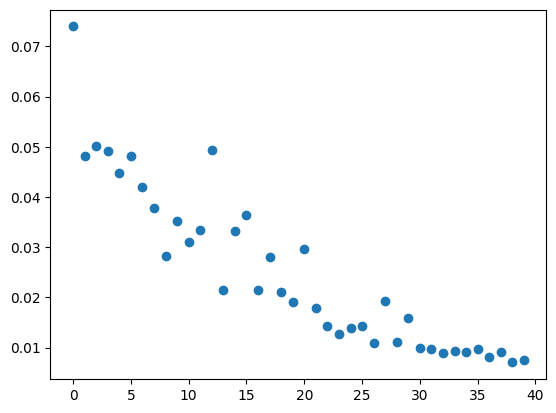

In [15]:
plt.scatter(range(niter), importance)

In [16]:
import math

# nshots_total = 1000
# nshots_iter = [math.floor(nshots_total * x) for x in importance]
# nshots_iter = [math.floor(nshots_total / len(importance)) for x in importance]

In [17]:
sim = Simulator('mqvector', nqubits)
# results = []
# estval = 0

def estimtate(nshots_total):
    estval = 0
    nshots_iter = [math.floor(nshots_total * x) for x in importance]
    for i in range(niter):
        circuit = OpenQASM().from_string(find_eval_replace_expressions(qasm_texts[i]))
        for j in range(nqubits):
            circuit += Measure(f'q{j}').on(j)
        sim.reset()
        sim.set_qs(reorder_qubits(stvec, nqubits))
        sim.apply_circuit(circuit)
        resstvec = sim.get_qs()
        diags_flip = reorder_qubits(diags[i], nqubits)
        result = sim.sampling(circuit, shots=nshots_iter[i])
        # results.append(result)
        contribution = estimate_diag(diags_flip, result.bit_string_data, nshots_iter[i])
        # print(i, contribution)
        estval += contribution
    return estval

In [18]:
nshots_total_list = range(500, 1001, 100)
nruns = 20
estval_list = [[estimtate(n) for n in nshots_total_list] for j in range(nruns)]

/home/yuxuan/.conda/envs/mindspore/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


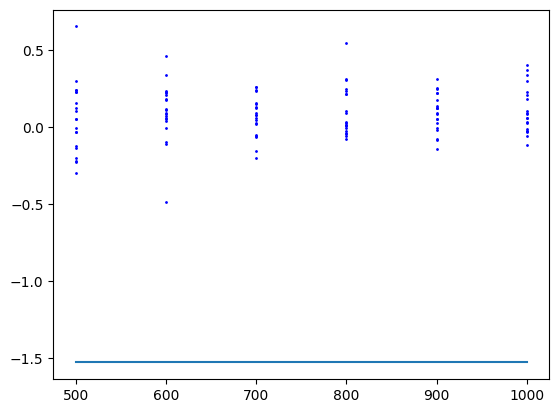

In [18]:
for j in range(nruns):
    plt.scatter(nshots_total_list, estval_list[j], c='blue', s=1)
plt.plot(nshots_total_list, [estval_st] * len(nshots_total_list))
# plt.plot(nshots_total_list, [eigenvalues[0]] * len(nshots_total_list))

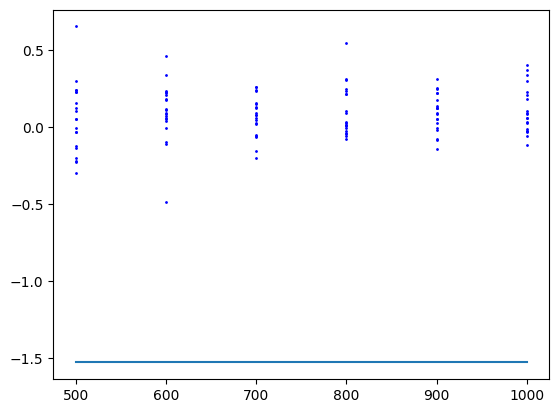

In [19]:
for j in range(nruns):
    plt.scatter(nshots_total_list, estval_list[j], c='blue', s=1)
plt.plot(nshots_total_list, [estval_st] * len(nshots_total_list))
# plt.plot(nshots_total_list, [eigenvalues[0]] * len(nshots_total_list))
# plt.ylim(-3.6, -3.2)

In [20]:
errors = np.array(estval_list)
# errors -= eigenvalues[0]
# errors -= estval.real
errors = np.sqrt(np.sum(errors**2, axis=0) / nruns)

In [21]:
errors

array([0.22981767, 0.21215502, 0.14572623, 0.19068036, 0.15318931,
       0.18416607])

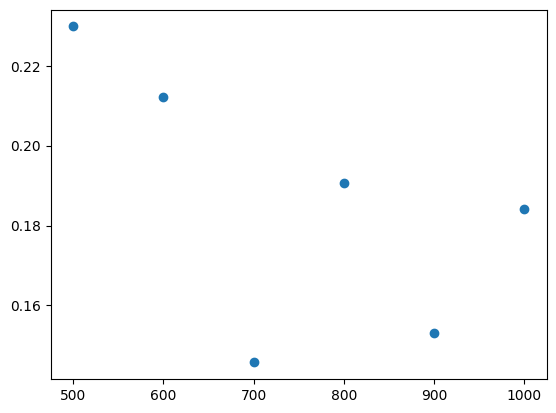

In [22]:
plt.scatter(nshots_total_list, errors)

In [23]:
np.savetxt('plotdata/sparse_error.txt', errors)